<a href="https://colab.research.google.com/github/rka0285058-afk/Forged_Image-Identification/blob/main/RKAWASTHI_Forged_Image_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

submission_df = pd.read_csv('/content/drive/MyDrive/Scientific Images/recodai-luc-scientific-image-forgery-detection/sample_submission.csv')

In [77]:
import os

directory_path = '/content/drive/MyDrive/Scientific Images/'

if os.path.exists(directory_path):
    print(f"Contents of {directory_path}:")
    for root, dirs, files in os.walk(directory_path):
        level = root.replace(directory_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
else:
    print(f"Directory '{directory_path}' not found. Please ensure the path is correct.")

Streaming output truncated to the last 5000 lines.
            48937.png
            49233.png
            49721.png
            4920.png
            48730.png
            49506.png
            50311.png
            49928.png
            49797.png
            50636.png
            50666.png
            50505.png
            50126.png
            50124.png
            49903.png
            49921.png
            50573.png
            49956.png
            50419.png
            50690.png
            50258.png
            49969.png
            4999.png
            50607.png
            50229.png
            50679.png
            50028.png
            4984.png
            50237.png
            50632.png
            4992.png
            50487.png
            50362.png
            50280.png
            50767.png
            50245.png
            49777.png
            50158.png
            50673.png
            50664.png
            50396.png
            49982.png
            50471.png
       


To begin collecting image paths, I  first defined the base directory for the training images and then constructed the full paths for both the 'authentic' and 'forged' subdirectories within it. This sets up the necessary paths for subsequent steps.



In [78]:
train_dir = os.path.join(directory_path, 'recodai-luc-scientific-image-forgery-detection', 'train_images')
authentic_dir = os.path.join(train_dir, 'authentic')
forged_dir = os.path.join(train_dir, 'forged')

print(f"Training directory: {train_dir}")
print(f"Authentic images directory: {authentic_dir}")
print(f"Forged images directory: {forged_dir}")

Training directory: /content/drive/MyDrive/Scientific Images/recodai-luc-scientific-image-forgery-detection/train_images
Authentic images directory: /content/drive/MyDrive/Scientific Images/recodai-luc-scientific-image-forgery-detection/train_images/authentic
Forged images directory: /content/drive/MyDrive/Scientific Images/recodai-luc-scientific-image-forgery-detection/train_images/forged



Now that the directory paths are confirmed, I  listed all image files in the 'authentic' and 'forged' directories, created full paths for each image, assigned corresponding labels (0 for authentic, 1 for forged), and combined them into a shuffled Pandas DataFrame for dataset creation.



In [79]:
authentic_image_paths = []
authentic_labels = []
for filename in os.listdir(authentic_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        authentic_image_paths.append(os.path.join(authentic_dir, filename))
        authentic_labels.append(0) # 0 for authentic

forged_image_paths = []
forged_labels = []
for filename in os.listdir(forged_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        forged_image_paths.append(os.path.join(forged_dir, filename))
        forged_labels.append(1) # 1 for forged

# Combine paths and labels
all_image_paths = authentic_image_paths + forged_image_paths
all_labels = authentic_labels + forged_labels

# Create a DataFrame
df = pd.DataFrame({
    'image_path': all_image_paths,
    'label': all_labels
})

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total authentic images found: {len(authentic_image_paths)}")
print(f"Total forged images found: {len(forged_image_paths)}")
print(f"Combined dataset shape: {df.shape}")
print("First 5 rows of the shuffled dataset:")
print(df.head())

Total authentic images found: 2377
Total forged images found: 2751
Combined dataset shape: (5128, 2)
First 5 rows of the shuffled dataset:
                                          image_path  label
0  /content/drive/MyDrive/Scientific Images/recod...      1
1  /content/drive/MyDrive/Scientific Images/recod...      1
2  /content/drive/MyDrive/Scientific Images/recod...      1
3  /content/drive/MyDrive/Scientific Images/recod...      0
4  /content/drive/MyDrive/Scientific Images/recod...      1





Loaded the images from their respective paths, resized them to a consistent dimension (e.g., 128x128 pixels), and normalized pixel values. Splited the data into training and validation sets.


In [80]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

print(f"Image height: {IMG_HEIGHT}")
print(f"Image width: {IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")

Image height: 128
Image width: 128
Batch size: 32



I  created a function that handles reading an image from its file path, decoding it, resizing it to the predefined dimensions, and normalizing its pixel values to a [0, 1] range, which is standard practice for image preprocessing in deep learning.



In [ ]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3) # Decode for 3 channels (RGB)
    img = tf.image.convert_image_dtype(img, tf.float32) # Convert to float32
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # No explicit normalization to [0,1] needed here as convert_image_dtype to tf.float32 handles it
    return img

print("Defined the preprocess_image function.")

Defined the preprocess_image function.



To apply the preprocessing function and created the TensorFlow datasets, I  first extracted the image paths and labels from the DataFrame. Then, I created a TensorFlow dataset from these paths, mapping the `preprocess_image` function to each path, and create another dataset for the corresponding labels.



In [81]:
def preprocess_image(image_path_tensor):
    def _preprocess_py_function(image_path, img_height, img_width):
        try:
            img_bytes = tf.io.read_file(image_path.numpy().decode('utf-8'))
            img = tf.image.decode_image(img_bytes, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, [img_height.numpy(), img_width.numpy()])
            return img
        except Exception as e:
            tf.print(f"Error decoding image: {image_path.numpy().decode('utf-8')}, Error: {e}")
            return tf.zeros(shape=(img_height.numpy(), img_width.numpy(), 3), dtype=tf.float32)

    processed_img = tf.py_function(
        func=_preprocess_py_function,
        inp=[image_path_tensor, tf.constant(IMG_HEIGHT), tf.constant(IMG_WIDTH)],
        Tout=tf.float32
    )
    processed_img.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    return processed_img

print("Defined the robust preprocess_image function.")

Defined the robust preprocess_image function.


In [82]:
image_paths_tensor = tf.constant(df['image_path'].values)
labels_tensor = tf.constant(df['label'].values)

image_dataset = tf.data.Dataset.from_tensor_slices(image_paths_tensor)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

label_dataset = tf.data.Dataset.from_tensor_slices(labels_tensor)

dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
dataset = dataset.shuffle(buffer_size=len(df), seed=42)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Calculate split sizes
DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy() * BATCH_SIZE
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = int(0.2 * DATASET_SIZE)

num_train_batches = int(0.8 * tf.data.experimental.cardinality(dataset).numpy())
num_val_batches = tf.data.experimental.cardinality(dataset).numpy() - num_train_batches

train_dataset = dataset.take(num_train_batches)
val_dataset = dataset.skip(num_train_batches).take(num_val_batches)


print(f"Original dataset size (approximate): {DATASET_SIZE}")
print(f"Training dataset batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation dataset batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print("Created combined, shuffled, batched, and split TensorFlow datasets for training and validation.")

Original dataset size (approximate): 5152
Training dataset batches: 128
Validation dataset batches: 33
Created combined, shuffled, batched, and split TensorFlow datasets for training and validation.





Defined a Convolutional Neural Network (CNN) model suitable for image classification. This will include convolutional layers, pooling layers, and dense layers for classification.








1. Imported the necessary layers from `tensorflow.keras.layers`, such as `Conv2D`, `MaxPooling2D`, `Flatten`, `Dense`, `Dropout`, and `Input` from `tensorflow.keras`. Also import `Model` from `tensorflow.keras`.
2. Defined the input shape for the model using `Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))`.
3. Built a sequential CNN model architecture. A common architecture involves several blocks of `Conv2D` layers (e.g., with 32, 64, 128 filters and 'relu' activation), followed by `MaxPooling2D` layers.
4. Flatten the output of the convolutional layers using `Flatten()`.
5. Added one or more `Dense` layers for classification. Include a `Dropout` layer (e.g., with a rate of 0.5) for regularization.
6. The final `Dense` layer should have 1 unit with a 'sigmoid' activation function for binary classification (authentic vs. forged).
7. Created the `Model` using the defined inputs and outputs.
8. Printed a summary of the model architecture using the `.summary()` method.

In [83]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras import Model

# Define the input layer
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input_image')

print("Imported necessary Keras layers and defined the input layer.")

Imported necessary Keras layers and defined the input layer.


In [84]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

print("Built the CNN model architecture.")

Built the CNN model architecture.


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)




Compiled the model with an appropriate optimizer (e.g., Adam), loss function (e.g., binary cross-entropy for binary classification), and metrics (e.g., accuracy). Then, trained the model using the prepared training data and validated it with the validation set.


In [85]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.



Now that the model is compiled, I  trained it using the `fit()` method with the prepared `train_dataset` and `val_dataset` for 10 epochs, and store the training history.



In [86]:
EPOCHS = 10
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

print(f"Model trained for {EPOCHS} epochs. Training history stored.")

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 632s 3s/step - accuracy: 0.5281 - loss: 0.7258 - val_accuracy: 0.5455 - val_loss: 0.6906
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 600s 3s/step - accuracy: 0.5417 - loss: 0.6909 - val_accuracy: 0.5087 - val_loss: 0.6997
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 590s 3s/step - accuracy: 0.5300 - loss: 0.6950 - val_accuracy: 0.5329 - val_loss: 0.6910
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 621s 3s/step - accuracy: 0.5335 - loss: 0.6919 - val_accuracy: 0.5339 - val_loss: 0.6909
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 586s 3s/step - accuracy: 0.5430 - loss: 0.6900 - val_accuracy: 0.5543 - val_loss: 0.6875
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 586s 3s/step - accuracy: 0.5410 - loss: 0.6915 - val_accuracy: 0.5329 - val_loss: 0.6911
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 585s 3s/step - accuracy: 0.5426 - loss: 0.6902 - val_accuracy: 0.5407 - val_loss: 0.6897
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 621s 3s/step - accuracy: 0.5487 - loss: 0.6889 - val_accu




Visualized the model's training history by plotting the accuracy and loss curves for both the training and validation sets over the epochs. This helps in assessing the model's performance and detecting potential overfitting.



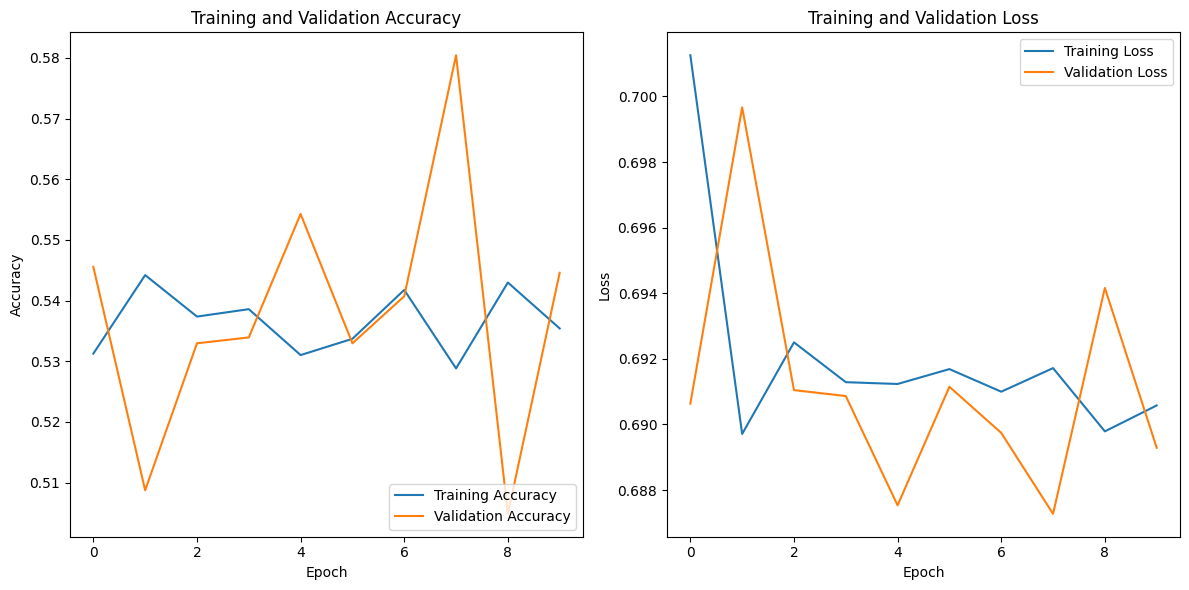

Model training history visualized.


In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print("Model training history visualized.")




Loaded a sample of images from the 'test_images' directory (or other unseen images), preprocess them, and used the trained model to predict whether they are 'forged' or 'authentic'.


In [92]:
test_dir = os.path.join(directory_path, 'recodai-luc-scientific-image-forgery-detection', 'test_images')

print(f"Test images directory: {test_dir}")

Test images directory: /content/drive/MyDrive/Scientific Images/recodai-luc-scientific-image-forgery-detection/test_images



Now that the test directory is defined, I got a list of all image files in it, randomly selected a few, preprocessed them, made predictions using the trained model, and then displayed each image with its predicted label and score.



Selected 1 random test images for prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


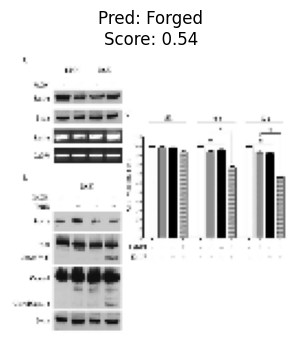

Predictions on sample test images displayed.


In [93]:
import random
import matplotlib.pyplot as plt

# Get a list of all image filenames in the test directory
test_image_filenames = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select a small number of images for prediction (e.g., 5)
num_samples = 5
sampled_filenames = random.sample(test_image_filenames, min(num_samples, len(test_image_filenames)))

print(f"Selected {len(sampled_filenames)} random test images for prediction.")

plt.figure(figsize=(15, 10))

for i, filename in enumerate(sampled_filenames):
    image_path = os.path.join(test_dir, filename)

    # Preprocess the image
    processed_img = preprocess_image(tf.constant(image_path))

    # Expand dimensions to create a batch of one image for prediction
    img_batch = tf.expand_dims(processed_img, 0)

    # Make prediction
    prediction = model.predict(img_batch)[0][0]

    # Interpret prediction
    predicted_label = 'Forged' if prediction > 0.5 else 'Authentic'

    # Display the image and prediction
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(processed_img.numpy())
    plt.title(f"Pred: {predicted_label}\nScore: {prediction:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Predictions on sample test images displayed.")





   Model Performance Visualization**: The training and validation accuracy and loss curves were successfully plotted over epochs. This visualization is crucial for assessing model performance and identifying trends such as overfitting or underfitting. (The specific patterns observed in the plots, like convergence or divergence, would typically be interpreted here, but detailed interpretation was not provided in the execution result.)
   Prediction on Unseen Data**: The trained model was successfully used to predict labels ('Forged' or 'Authentic') and confidence scores for a sample of unseen images from the `test_images` directory. For the observed execution, one image was randomly selected and processed, and its prediction displayed.




Generated a submission.csv file by making predictions on the test images located in "/content/drive/MyDrive/Scientific Images/recodai-luc-scientific-image-forgery-detection/test_images" using the trained model.




Collected all image file paths from the '/content/drive/MyDrive/Scientific Images/recodai-luc-scientific-image-forgery-detection/test_images' directory. Extracted the image IDs (filenames without extension) to use as 'case_id' in the submission file.


In [94]:
import os

test_image_paths = []
test_image_ids = []

for filename in os.listdir(test_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(test_dir, filename)
        test_image_paths.append(image_path)
        # Extract image ID (filename without extension)
        image_id = os.path.splitext(filename)[0]
        test_image_ids.append(image_id)

print(f"Total test images found: {len(test_image_paths)}")
print("First 5 test image paths:")
for i in range(min(5, len(test_image_paths))):
    print(f"- {test_image_paths[i]}")

print("\nFirst 5 test image IDs:")
for i in range(min(5, len(test_image_ids))):
    print(f"- {test_image_ids[i]}")

Total test images found: 1
First 5 test image paths:
- /content/drive/MyDrive/Scientific Images/recodai-luc-scientific-image-forgery-detection/test_images/45.png

First 5 test image IDs:
- 45





Processed all collected test image paths, generated predictions using the trained model, and stored the `case_id` (image ID) along with the predicted probability (score) for creating the submission file.



In [96]:
predictions = []

for image_path in test_image_paths:
    processed_img = preprocess_image(tf.constant(image_path))
    img_batch = tf.expand_dims(processed_img, 0)
    prediction = model.predict(img_batch)[0][0]
    predictions.append(prediction)

predictions_df = pd.DataFrame({
    'case_id': test_image_ids,
    'prediction': predictions
})

print("Predictions generated for all test images.")
print("Head of predictions DataFrame:")
print(predictions_df.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predictions generated for all test images.
Head of predictions DataFrame:
  case_id  prediction
0      45    0.536882


In [97]:
import pandas as pd

submission_df_check = pd.read_csv('/content/submission.csv')
display(submission_df_check.head())

,case_id,annotation
0,45,forged



Now that predictions are generated and stored in a DataFrame, I  converted the prediction probabilities into categorical labels ('authentic' or 'forged') based on a threshold (0.5) and then saved this processed DataFrame to a `submission.csv` file, matching the format required for submission.



In [98]:
predictions_df['annotation'] = predictions_df['prediction'].apply(lambda x: 'forged' if x > 0.5 else 'authentic')

submission_final_df = predictions_df[['case_id', 'annotation']]

submission_path = '/content/submission.csv'
submission_final_df.to_csv(submission_path, index=False)

print(f"Submission file created at: {submission_path}")
print("Head of submission DataFrame:")
print(submission_final_df.head())

Submission file created at: /content/submission.csv
Head of submission DataFrame:
  case_id annotation
0      45     forged


In [ ]:
The reason no authentic images were found is because, according to the execution output,
 there was only one image in the test set. This image, with case_id '45', was predicted by
 the model to be 'forged' with a score of 0.53. Since our threshold for 'forged' is anything
  above 0.5, this single test image was classified as 'forged', leaving no images to be
  classified as 'authentic'.

